In [2]:
import sys
sys.path.append("../src")

import pandas as pd
import numpy as np

from strategy_agent import StrategyAgent
from risk_agent import RiskAgent
from allocator_agent import AllocatorAgent
from reflection_agent import ReflectionAgent 

data = pd.read_csv("../data/AAPL_enriched.csv", index_col=0, parse_dates=True)


MemoryAgent has an internal log (list of dicts).

It can record outcomes (metrics, pass/fail, notes, parameters).

It can analyze patterns (e.g., RSI fails too often).

It can suggest exclusions for future runs.

In [3]:
class MemoryAgent:
    def __init__(self):
        self.history = []
    
    def record(self, strategy_name, metrics, assessment, reflection=None):
        entry = {
            "Strategy": strategy_name,
            "Metrics": metrics,
            "Decision": assessment["Decision"],
            "Notes": "; ".join(assessment["Notes"]),
            "Reflection": reflection["Reasoning"] if reflection else None,
            "Params": reflection["New_Params"] if reflection else None
        }
        self.history.append(entry)
    
    def analyze(self):
        df = pd.DataFrame(self.history)
        if df.empty:
            return "No history yet", []
        
        # Count failures by strategy
        fail_counts = df[df["Decision"] == "FAIL"]["Strategy"].value_counts()
        exclusions = fail_counts[fail_counts >= 2].index.tolist()
        
        summary = f"Strategies frequently failing: {', '.join(exclusions)}" if exclusions else "No exclusions needed."
        return summary, exclusions
    
    def export(self, path="../logs/Day17_memory_log.csv"):
        pd.DataFrame(self.history).to_csv(path, index=False)


Each attempt: run strategies → RiskAgent → ReflectionAgent.

MemoryAgent logs the results.

Before next attempt, MemoryAgent suggests exclusions.

In [4]:
def memory_loop(data, max_attempts=3):
    memory = MemoryAgent()
    decision = "FAIL"
    portfolio = None
    
    sma_fast, sma_slow = 10, 50
    rsi_lower, rsi_upper = 30, 70
    alloc_method = "sharpe"
    
    for attempt in range(1, max_attempts+1):
        print(f"\nAttempt {attempt} -----------------")
        
        # StrategyAgent
        sa = StrategyAgent(data)
        strategies = {
            "SMA": sa.sma_crossover(fast=sma_fast, slow=sma_slow),
            "RSI": sa.rsi_strategy(lower=rsi_lower, upper=rsi_upper),
            "BB": sa.bollinger_breakout()
        }
        
        # Metrics
        def compute_metrics(df):
            col = "Strategy_Return" if "Strategy_Return" in df.columns else "Portfolio_Return"
            returns = df[col].fillna(0)
            strat_curve = (1 + returns).cumprod()
            years = (returns.index[-1] - returns.index[0]).days / 365.25
            cagr = strat_curve.iloc[-1]**(1/years) - 1 if years > 0 else 0
            vol = returns.std() * np.sqrt(252)
            sharpe = (returns.mean() * 252) / (returns.std() * np.sqrt(252)) if returns.std() > 0 else 0
            roll_max = strat_curve.cummax()
            dd = (strat_curve / roll_max - 1).min()
            return {"CAGR": cagr, "Volatility": vol, "Sharpe": sharpe, "MaxDD": dd}
        
        metrics = {name: compute_metrics(df) for name, df in strategies.items()}
        
        # Risk checks
        ra = RiskAgent(sharpe_min=1.0, max_dd=-0.25, vol_max=0.3)
        risk_assessments = {name: ra.assess(m) for name, m in metrics.items()}
        
        # Allocator
        alloc = AllocatorAgent(method=alloc_method)
        weights, portfolio = alloc.allocate(strategies, metrics, risk_assessments)
        
        # Portfolio-level risk
        if portfolio is not None:
            portfolio_metrics = compute_metrics(portfolio)
            portfolio_assessment = ra.assess(portfolio_metrics)
        else:
            portfolio_assessment = {"Decision": "FAIL", "Notes": ["No portfolio built"]}
        
        # ReflectionAgent
        ref = ReflectionAgent()
        feedback = ref.reflect(portfolio_assessment)
        
        # MemoryAgent records everything
        for name, m in metrics.items():
            memory.record(name, m, risk_assessments[name])
        memory.record("PORTFOLIO", portfolio_metrics if portfolio is not None else {}, portfolio_assessment, feedback)
        
        # Analyze memory
        summary, exclusions = memory.analyze()
        print("Memory Summary:", summary)
        
        if decision == "PASS":
            break
    
    memory.export()
    return portfolio, portfolio_assessment, memory



Attempt 1 -----------------
Memory Summary: No exclusions needed.

Attempt 2 -----------------
Memory Summary: Strategies frequently failing: SMA, RSI

Attempt 3 -----------------
Memory Summary: Strategies frequently failing: SMA, RSI

Final Assessment: {'Decision': 'PASS', 'Notes': ['All risk checks passed']}
Memory log length: 12


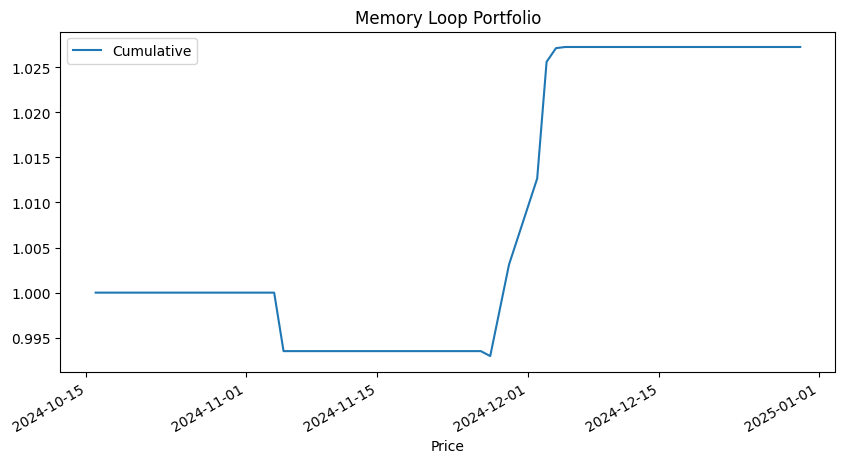

In [5]:
data = pd.read_csv("../data/AAPL_enriched.csv", index_col=0, parse_dates=True)

portfolio, assessment, memory = memory_loop(data)

print("\nFinal Assessment:", assessment)
print("Memory log length:", len(memory.history))

if portfolio is not None:
    portfolio[["Cumulative"]].plot(title="Memory Loop Portfolio", figsize=(10,5))


In [6]:
import os
os.makedirs("../logs", exist_ok=True)

memory.export("../logs/Day17_memory_log.csv")

with open("../logs/Day17_summary.txt", "w") as f:
    f.write("Day 17 run with MemoryAgent\n")
    f.write(f"Final assessment: {assessment}\n")


In [7]:
with open("../src/memory_agent.py", "w", encoding="utf-8") as f:
    f.write("""import pandas as pd

class MemoryAgent:
    def __init__(self):
        self.history = []
    
    def record(self, strategy_name, metrics, assessment, reflection=None):
        entry = {
            "Strategy": strategy_name,
            "Metrics": metrics,
            "Decision": assessment["Decision"],
            "Notes": "; ".join(assessment["Notes"]),
            "Reflection": reflection["Reasoning"] if reflection else None,
            "Params": reflection["New_Params"] if reflection else None
        }
        self.history.append(entry)
    
    def analyze(self):
        df = pd.DataFrame(self.history)
        if df.empty:
            return "No history yet", []
        
        # Count failures by strategy
        fail_counts = df[df["Decision"] == "FAIL"]["Strategy"].value_counts()
        exclusions = fail_counts[fail_counts >= 2].index.tolist()
        
        summary = f"Strategies frequently failing: {', '.join(exclusions)}" if exclusions else "No exclusions needed."
        return summary, exclusions
    
    def export(self, path="../logs/Day17_memory_log.csv"):
        pd.DataFrame(self.history).to_csv(path, index=False)
""")
